In [50]:
import pandas as pd
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import cellbell

In [4]:
df = pd.read_csv('/Users/ianbury/Downloads/chckpt1.csv')

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
df.position.unique()

array(['DT', 'UNK', 'DE', 'LB', 'DB', 'RB', 'LS', 'WR', 'OT', 'QB', 'OG',
       'TE', 'P', 'C', 'NT', 'K', 'CB', 'SAF', 'T', 'OLB'], dtype=object)

In [7]:
pos=['QB','WR','RB','TE']

In [8]:
df=df[df.position.isin(pos)]

In [9]:
df_clean=df[['position','day_of_week','week','fantasy_score','desc_simple', 'prev_score', 'avg3_score', 'avg5_score', 'avg3_tar',
       'avg5_tar', 'avg3_rush_att', 'avg5_rush_att', 'prev_tar',
       'prev_rush_att', 'prev_pass_att', 'avg3_pass_att', 'avg5_pass_att']]

In [10]:
len(df_clean)

21343

In [11]:
df_clean=df_clean.dropna()

In [12]:
df_clean.fantasy_score.unique()

array([ 0. ,  5.4,  0.4, ..., 33.5, 17.1, -2.5])

In [13]:
dff=pd.get_dummies(df_clean)

In [14]:
dff.columns

Index(['week', 'fantasy_score', 'prev_score', 'avg3_score', 'avg5_score',
       'avg3_tar', 'avg5_tar', 'avg3_rush_att', 'avg5_rush_att', 'prev_tar',
       'prev_rush_att', 'prev_pass_att', 'avg3_pass_att', 'avg5_pass_att',
       'position_QB', 'position_RB', 'position_TE', 'position_WR',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Wednesday',
       'desc_simple_Good', 'desc_simple_Snowy', 'desc_simple_Wet',
       'desc_simple_Windy'],
      dtype='object')

In [15]:
X=dff.drop('fantasy_score',axis=1)
y=dff.fantasy_score.values.reshape(-1,1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)

In [17]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_train)
lm.score(X_train,y_train)

0.3349554341168567

In [18]:
y_pred = lm.predict(X_test)
mean_squared_error(y_test,y_pred)

40.73389527648333

In [19]:
res = y_pred - y_test

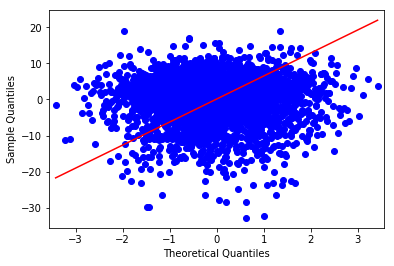

In [20]:
sm.qqplot(res,line='s')
plt.show()

In [21]:
lm.coef_

array([[-1.45480876e-01, -5.77014743e-03, -4.35995743e-03,
         3.97349358e-01,  1.24813488e-01,  3.50371872e-01,
         3.34413801e-02,  1.03439957e-01, -2.80906526e-02,
         7.60331350e-02,  3.69280454e-03,  6.64744257e-02,
        -7.68701802e-02,  5.68372676e+00, -1.91978806e+00,
        -2.46867087e+00, -1.29526783e+00, -2.27964595e+00,
         7.79993789e-01,  1.70052972e+00,  5.68523234e-01,
         3.67031117e-01, -1.13643190e+00,  2.49530162e-01,
         3.18174155e-01, -3.18972384e-01, -2.48731933e-01]])

In [22]:
cv_results = cross_val_score(lm,X_train,y_train,cv=10)

In [23]:
np.mean(cv_results)

0.330456007924256

In [24]:
en = ElasticNet()
l1_space= np.linspace(0,1,30)
param_grid = {'l1_ratio':l1_space}
gs = GridSearchCV(en,param_grid, cv=10)
gs.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([0.     , 0.03448, 0.06897, 0.10345, 0.13793, 0.17241, 0.2069 ,
       0.24138, 0.27586, 0.31034, 0.34483, 0.37931, 0.41379, 0.44828,
       0.48276, 0.51724, 0.55172, 0.58621, 0.62069, 0.65517, 0.68966,
       0.72414, 0.75862, 0.7931 , 0.82759, 0.86207, 0.89655, 0.93103,
       0.96552, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
gs.score(X_test,y_test)

0.3279998492550893

In [26]:
y_pred = gs.predict(X_test)
mean_squared_error(y_test,y_pred)

42.55654843416462

In [29]:
r=Ridge(normalize=True)
alpha_space = np.logspace(-4, 0, 50)
params = {'alpha':alpha_space}
gs_r = GridSearchCV(r,params,cv=10)
gs_r.fit(X_train,y_train)
gs_r.score(X_train,y_train)

0.334767170016814

In [30]:
y_pred = gs_r.predict(X_test)
mean_squared_error(y_test,y_pred)

40.73451477319756

In [31]:
l = Lasso()
alpha_space = np.logspace(-4, 0, 50)
params = {'alpha':alpha_space}
gs_l = GridSearchCV(l,params,cv=10)
gs_l.fit(X_train,y_train)
gs_l.score(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.33482036602087084

In [32]:
y_pred = gs_l.predict(X_test)
mean_squared_error(y_test,y_pred)

40.68926422797477

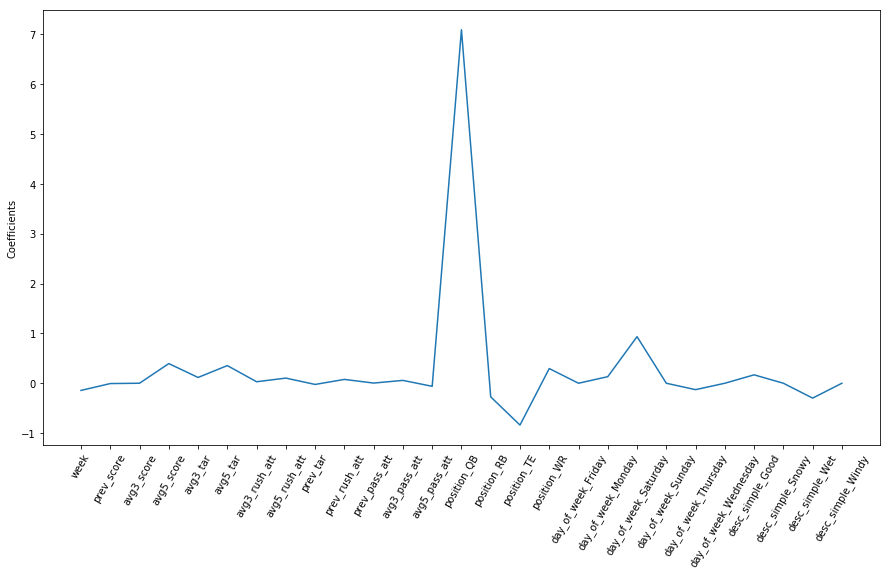

In [33]:
names = X.columns
plt.figure(figsize=(15,8))
_=plt.plot(range(len(names)),gs_l.best_estimator_.coef_)
_=plt.xticks(range(len(names)),names,rotation=60)
_=plt.ylabel('Coefficients')

In [34]:
aa = pd.DataFrame({'Factor':np.array(list(X.columns)),'Coefficient':gs_l.best_estimator_.coef_})

In [35]:
aa.sort_values('Coefficient',ascending=False)

,Factor,Coefficient
13,position_QB,7.093368
19,day_of_week_Saturday,0.934437
3,avg5_score,0.394338
5,avg5_tar,0.353940
16,position_WR,0.294639
23,desc_simple_Good,0.168627
18,day_of_week_Monday,0.131929
4,avg3_tar,0.115873
7,avg5_rush_att,0.102962
9,prev_rush_att,0.076845


In [102]:
#RandomForest
rf=RandomForestRegressor()

#gs_rf = GridSearchCV(rf,random_grid,cv=3)
rf.fit(X_train,y_train.ravel())
rf.score(X_train,y_train)

0.8394518508286908

In [103]:
y_pred = rf.predict(X_test)
mean_squared_error(y_test,y_pred)

45.47138423235147

In [53]:
rf=RandomForestRegressor()

gs_rf = RandomizedSearchCV(rf,random_grid,cv=3)
gs_rf.fit(X_train,y_train.ravel())
gs_rf.score(X_train,y_train)

0.5998595285800828

In [101]:
y_pred_random = gs_rf.predict(X_test)
mean_squared_error(y_test,y_pred_random)

39.60176085855898

In [52]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

dd
